In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate
import scipy.optimize as optimize

In [2]:
plt.style.use("../style1.mplstyle")

# Two species - One Resource

## Effective interactions for coexistence and monodnomiance

### Invasion criteria for coexistence in transfers

In [3]:
@njit
def fn(K1,K2,mu1,mu2,y1,y2,R,d):
    return ((1+R/K2)**(K1-K2) / d**(K1 + R/(1-d)))**(mu2 * y2 / (mu1 * y1) / (K2 + R/(1-d)))

@njit
def species_survivability(km,mu,d,tau,c0):
    return -np.log(d)/tau<mu*c0/(km+c0)

In [4]:
a1,a2 = 0.2,0.57
K1,K2 = 0.06,5.1
y1,y2 = 1,1

alpha_vec = np.array([a1,a2])
K_vec = np.array([K1,K2])
yield_vec = np.array([y1,y2])

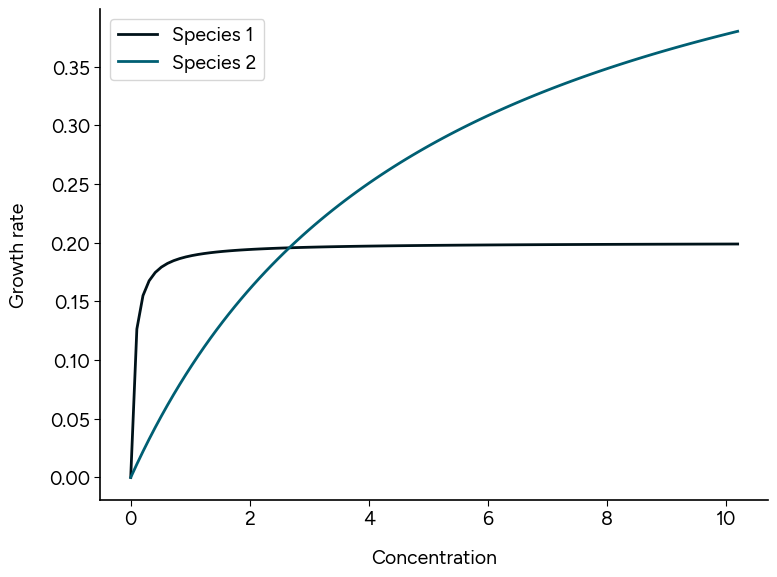

In [5]:
plotconc = np.linspace(0,np.max([K1,K2])*2,100)
plt.plot(plotconc,a1*plotconc/(K1+plotconc),label="Species 1")
plt.plot(plotconc,a2*plotconc/(K2+plotconc),label="Species 2")
plt.xlabel("Concentration")
plt.ylabel("Growth rate")
plt.legend()

In [6]:
supply_conc = 10
dilution_times = np.geomspace(2,72,20)[::-1]
chemostat_dilution = 0.1
dilution_fractions = np.exp(-chemostat_dilution*dilution_times)

In [7]:
survived_species = np.zeros(dilution_times.size)
warrays = np.zeros((dilution_times.size,2))
incount = 0

for j in range(dilution_times.size):
    d = dilution_fractions[j]
    tau = dilution_times[j]
    c0 = supply_conc
    sp1survival = species_survivability(K1,a1,d,tau,c0)
    sp2survival = species_survivability(K2,a2,d,tau,c0)

    if(sp1survival and sp2survival):
        incount+=1
        
        w2 = d * fn(K1,K2,a1,a2,1,1,c0*(1-d),d)
        w1 = d * fn(K2,K1,a2,a1,1,1,c0*(1-d),d)

        warrays[j,0] = w1
        warrays[j,1] = w2
        
        if(w1 >= 1 and w2 < 1):
            survived_species[j] = 1
        if(w2 >= 1 and w1 < 1):
            survived_species[j] = 2
        if(w1 >= 1 and w2 >= 1):
            survived_species[j] = 1.5

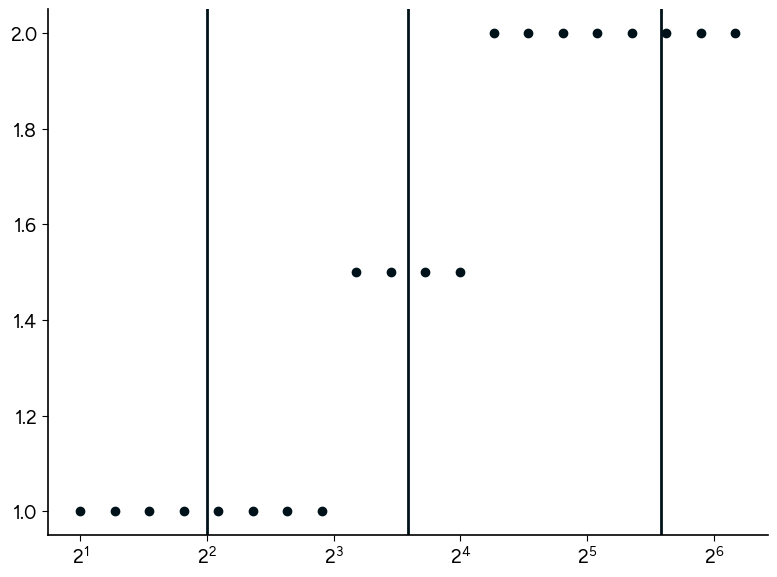

In [8]:
plt.plot(dilution_times,survived_species,"o")
plt.xscale('log',base=2)
plt.axvline(12)
plt.axvline(4)
plt.axvline(48)

### Simulation of dynamics for interactions

In [9]:
@njit
def serial_dilutions(y,t,alpha1,alpha2,km1,km2,yiel1,yiel2):
    n1 = y[0]
    n2 = y[1]
    cres = y[2]

    n1dot = n1*alpha1*cres/(km1+cres)
    n2dot = n2*alpha2*cres/(km2+cres)
    cresdot = - n1*alpha1*cres/(km1+cres)/yiel1 - n2*alpha2*cres/(km2+cres)/yiel2


    return np.array([n1dot,n2dot,cresdot])

@njit
def rk4_integrator_conserved(ycur,t,dt,alpha1,alpha2,km1,km2,yiel1,yiel2,s_vector,next_dilution,time_dilutions,dilution_factor):
    y = ycur.copy()
    if(next_dilution<len(time_dilutions)):
        if(np.round(t,5)<time_dilutions[next_dilution] and np.round(t+dt,5) >= time_dilutions[next_dilution]):
            y[:2] = y[:2] * dilution_factor
            y[2:] = (1-dilution_factor)*s_vector + y[2] * dilution_factor                                    
            next_dilution += 1
        else:
            k1 = serial_dilutions(y,t,alpha1,alpha2,km1,km2,yiel1,yiel2)
            k2 = serial_dilutions(y+dt*k1/2.0,t+dt/2.0,alpha1,alpha2,km1,km2,yiel1,yiel2)
            k3 = serial_dilutions(y+dt*k2/2.0,t+dt/2.0,alpha1,alpha2,km1,km2,yiel1,yiel2)
            k4 = serial_dilutions(y+dt*k3,t+dt,alpha1,alpha2,km1,km2,yiel1,yiel2)
            y = y + dt*(k1+2*k2+2*k3+k4)/6.0
    else:
        k1 = serial_dilutions(y,t,alpha1,alpha2,km1,km2,yiel1,yiel2)
        k2 = serial_dilutions(y+dt*k1/2.0,t+dt/2.0,alpha1,alpha2,km1,km2,yiel1,yiel2)
        k3 = serial_dilutions(y+dt*k2/2.0,t+dt/2.0,alpha1,alpha2,km1,km2,yiel1,yiel2)
        k4 = serial_dilutions(y+dt*k3,t+dt,alpha1,alpha2,km1,km2,yiel1,yiel2)
        y = y + dt*(k1+2*k2+2*k3+k4)/6.0
    return y,next_dilution

@njit
def dilution_integrate_conserved(y0,alpha1,alpha2,km1,km2,yiel1,yiel2,s_vector,time_dilutions,dilution_factor,dt,t_integrate):
    y = np.zeros((len(t_integrate),len(y0)),dtype=np.float64)
    y[0] = y0

    next_dilution = 0
    for i in range(1,len(t_integrate)):
        ytemp,next_dilution = rk4_integrator_conserved(y[i-1],t_integrate[i-1],dt,alpha1,alpha2,km1,km2,yiel1,yiel2,s_vector,next_dilution,time_dilutions,dilution_factor)
        y[i] = ytemp
    return y

In [10]:
def effIntFn(alpha_vec,K_vec,yield_vec,c,sp1id,sp2id):
    id1,id2 = sp1id-1,sp2id-1
    return - alpha_vec[id1] * K_vec[id1] / (K_vec[id1] + c)**2 * alpha_vec[id2] * c / (K_vec[id2] + c) / yield_vec[id2]

In [11]:
y_init = np.array([y1/2,y2/2,supply_conc])

dt = 1e-4
t_integrate = np.arange(0,480,dt)

In [12]:
times_dilution_sim = np.array([0.005,1,12,48])
dils_frac_sim = np.zeros(times_dilution_sim.size)
simulation_data = []

for i in range(len(times_dilution_sim)):
    dils_frac_sim[i] = np.exp(-chemostat_dilution * times_dilution_sim[i])
    t_dilutions = np.arange(0,t_integrate[-1],times_dilution_sim[i])[1:]
    simulation_data.append(dilution_integrate_conserved(y_init,a1,a2,K1,K2,y1,y2,supply_conc,t_dilutions,dils_frac_sim[i],dt,t_integrate))

In [13]:
interaction_array = np.zeros((times_dilution_sim.size,2,2,t_integrate.size))

for i in range(times_dilution_sim.size):
    conc_sim = simulation_data[i][:,2]
    for j in range(2):
        for k in range(2):
            interaction_array[i,j,k] = effIntFn(alpha_vec,K_vec,yield_vec,conc_sim,j+1,k+1)

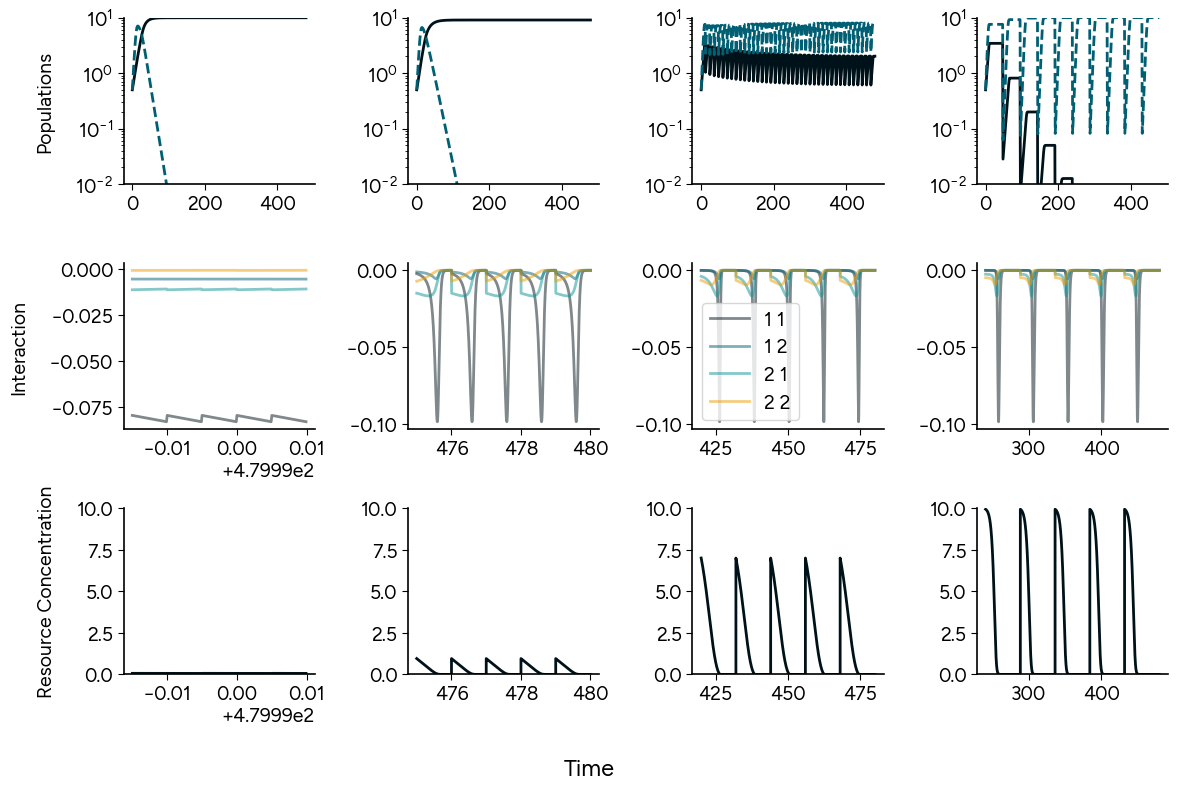

In [14]:
fig,ax = plt.subplots(3,len(times_dilution_sim),figsize=(12,8))

for i in range(times_dilution_sim.size):
    y_soln = simulation_data[i]
    ax[0,i].plot(t_integrate[::10000],y_soln[:,0][::10000])
    ax[0,i].plot(t_integrate[::10000],y_soln[:,1][::10000],ls="--")
    ax[0,i].set_yscale('log')

    cutoff = -int(5 * times_dilution_sim[i]/dt)
    conc_sim = simulation_data[i][:,2]
    
    for j in range(2):
        for k in range(2):
            if(i==2):
                ax[1,i].plot(t_integrate[cutoff:],-(np.abs(interaction_array[i,j,k,cutoff:]) ),alpha=0.5,label="%d %d"%(j+1,k+1))
                ax[1,i].legend()
            else:
                ax[1,i].plot(t_integrate[cutoff:],-(np.abs(interaction_array[i,j,k,cutoff:]) ),alpha=0.5)
    ax[2,i].plot(t_integrate[cutoff:],conc_sim[cutoff:])

    

    ax[0,i].set_yscale("log")
    ax[0,i].set_ylim(1e-2,1e1)
    # ax[1,i].set_yscale("log")
    # ax[1,i].set_xscale("log")
    # ax[1,i].set_xlim(-0.5,10)
    # ax[1,i].set_ylim(-8,)

    
    ax[2,i].set_ylim(0,10)

ax[0,0].set_ylabel("Populations")
ax[1,0].set_ylabel("Interaction")
ax[2,0].set_ylabel("Resource Concentration")
# ax[0,1].set_xlabel("Time")
# ax[1,1].set_xlabel("Time")
# ax[2,1].set_xlabel("Time")

fig.supxlabel("Time")
plt.show()


In [16]:
integrated_interaction = np.zeros((times_dilution_sim.size,2,2))
growth_matrix = np.zeros((times_dilution_sim.size,2))
intergated_growth = np.zeros((times_dilution_sim.size,2))

In [17]:
for i in range(times_dilution_sim.size):
    lastdil = -int(times_dilution_sim[i]/dt)
    conc_sim = simulation_data[i][:,2]
    for j in range(2):
        for k in range(2):
            integrated_interaction[i,j,k] = integrate.simpson(interaction_array[i,j,k,lastdil:],x=t_integrate[lastdil:])
        growth_matrix[i,j] = alpha_vec[j] * conc_sim[lastdil] / (K_vec[j] + conc_sim[lastdil])
        intergated_growth[i,j] = -integrate.simpson(alpha_vec[j] * conc_sim[lastdil:] / (K_vec[j] + conc_sim[lastdil:]),x=conc_sim[lastdil:])
    print(conc_sim[lastdil])

0.06503311531055159
0.9516258748065357
6.98805788087798
9.9177025295098


### Fitting chemostat to GLV

In [18]:
dt = 1e-5
t_integrate = np.arange(0,240,dt)

In [19]:
fast_dilution_time = 0.001
fast_dils_factor = np.exp(-chemostat_dilution * fast_dilution_time)
fast_t_dilutions = np.arange(0,t_integrate[-1],fast_dilution_time)[1:]

In [20]:
sp1ic = np.array([y1/2,0,supply_conc*(1-fast_dils_factor)])
sp2ic = np.array([0,y2/2,supply_conc*(1-fast_dils_factor)])
spcocul = np.array([y1/2,y2/2,supply_conc*(1-fast_dils_factor)])

sp1soln = dilution_integrate_conserved(sp1ic,a1,a2,K1,K2,y1,y2,supply_conc,fast_t_dilutions,fast_dils_factor,dt,t_integrate)
sp2soln = dilution_integrate_conserved(sp2ic,a1,a2,K1,K2,y1,y2,supply_conc,fast_t_dilutions,fast_dils_factor,dt,t_integrate)
spcosoln = dilution_integrate_conserved(spcocul,a1,a2,K1,K2,y1,y2,supply_conc,fast_t_dilutions,fast_dils_factor,dt,t_integrate)

In [21]:
fast_dilution_interaction_array = np.zeros((2,2,t_integrate.size))

for j in range(2):
    for k in range(2):
        fast_dilution_interaction_array[j,k] = effIntFn(alpha_vec,K_vec,yield_vec,spcosoln[:,2],j+1,k+1)

In [22]:
fitting_cutoff = t_integrate.size//2

chemostat_sp1_data = sp1soln[:fitting_cutoff:1000]
chemostat_sp2_data = sp2soln[:fitting_cutoff:1000]
chemostat_coculture_data = spcosoln[:fitting_cutoff:1000]
chemostat_times = t_integrate[:fitting_cutoff:1000]

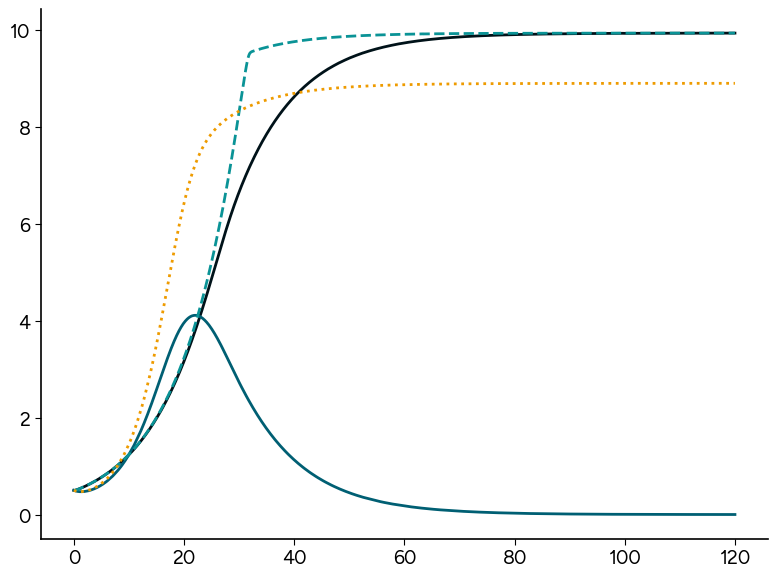

In [23]:
plt.plot(chemostat_times,chemostat_coculture_data[:,0])
plt.plot(chemostat_times,chemostat_coculture_data[:,1])
plt.plot(chemostat_times,chemostat_sp1_data[:,0],ls="--")
plt.plot(chemostat_times,chemostat_sp2_data[:,1],ls="dotted")


In [24]:
def logistic_solution(t,g,alpha,x0):
    return x0 * g/alpha  / ((g/alpha - x0)*np.exp(-g*t) + x0)

In [25]:
theory_soln_sp1 = lambda t,g,alpha: logistic_solution(t,g,alpha,y1/2)
theory_soln_sp2 = lambda t,g,alpha: logistic_solution(t,g,alpha,y2/2)

In [26]:
sp1fitvals,sp1fitcorr  = optimize.curve_fit(theory_soln_sp1,chemostat_times,chemostat_sp1_data[:,0],p0=[1,1],bounds=([0,0],[np.inf,np.inf]))
sp2fitvals,sp2fitcorr  = optimize.curve_fit(theory_soln_sp2,chemostat_times,chemostat_sp2_data[:,1],p0=[1,1],bounds=([0,0],[np.inf,np.inf]))

g1fit , a11fit = sp1fitvals
g2fit , a22fit = sp2fitvals

In [27]:
sp1fitvals

array([0.13301597, 0.0132146 ])

In [28]:
sp1fitvals

array([0.13301597, 0.0132146 ])

In [29]:
sp2fitvals

array([0.17619338, 0.01977652])

In [30]:
sp2fitvals

array([0.17619338, 0.01977652])

In [31]:
interaction_array[0,:,:,-1]

array([[-0.08328904, -0.00552319],
       [-0.01092359, -0.00072438]])

In [32]:
interaction_array[0,:,:,-1]

array([[-0.08328904, -0.00552319],
       [-0.01092359, -0.00072438]])

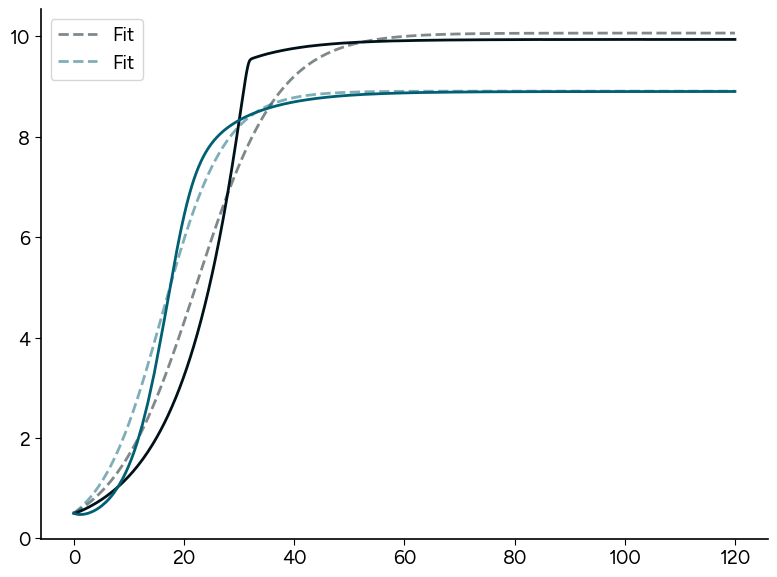

In [33]:
plt.plot(chemostat_times,theory_soln_sp1(chemostat_times,g1fit,a11fit),ls="--",color="C0",label="Fit",alpha=0.5)
plt.plot(chemostat_times,theory_soln_sp2(chemostat_times,g2fit,a22fit),ls="--",color="C1",label="Fit",alpha=0.5)

plt.plot(chemostat_times,chemostat_sp1_data[:,0],color="C0")
plt.plot(chemostat_times,chemostat_sp2_data[:,1],color="C1")	

plt.legend()
plt.show()

In [34]:
@njit
def glv_rhs(t,y,gvec,alphamatrix):
    dydot = y*(gvec - np.dot(alphamatrix,y))
    return dydot

In [35]:
growth = np.array([g1fit,g2fit])

In [36]:
def glv_fitting(t,a12,a21):
    interactions = np.array([[a11fit,a12],[a21,a22fit]])
    integrated_soln = integrate.solve_ivp(glv_rhs,[0,t],np.array([y1/2,y2/2]),args=(growth,interactions))
    return integrated_soln.y[:,-1]

In [37]:
def glv_error(off_diag_interactions):
    a12,a21 = off_diag_interactions
    interactions = np.array([[a11fit,a12],[a21,a22fit]])
    integrated_soln = integrate.solve_ivp(glv_rhs,[0,chemostat_times[-1]],np.array([y1/2,y2/2]),args=(growth,interactions),t_eval=chemostat_times)
    return np.sum((integrated_soln.y.T - chemostat_coculture_data[:,:2])**2)

In [38]:
coculture_lsqsq = optimize.minimize(glv_error,[0,0],method="Nelder-Mead")

In [39]:
a12fit,a21fit = coculture_lsqsq.x

In [40]:
glv_interaction_matrix = np.array([[a11fit,a12fit],[a21fit,a22fit]])
glv_growth_matrix = np.array([g1fit,g2fit])

In [41]:
sim_glv_coculture = integrate.solve_ivp(glv_rhs,[0,chemostat_times[-1]],np.array([y1/2,y2/2]),args=(glv_growth_matrix,glv_interaction_matrix,),t_eval=chemostat_times)
sim_glv_sp1 = integrate.solve_ivp(glv_rhs,[0,chemostat_times[-1]],np.array([y1/2,0]),args=(glv_growth_matrix,glv_interaction_matrix,),t_eval=chemostat_times)
sim_glv_sp2 = integrate.solve_ivp(glv_rhs,[0,chemostat_times[-1]],np.array([0,y2/2]),args=(glv_growth_matrix,glv_interaction_matrix,),t_eval=chemostat_times)

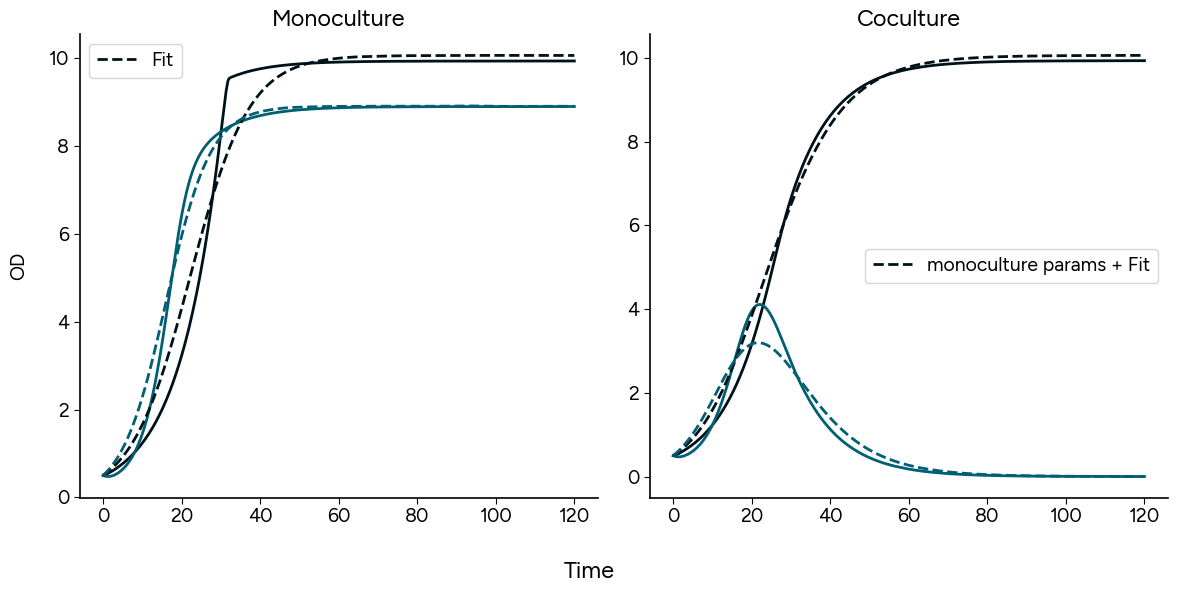

In [42]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(chemostat_times,chemostat_sp1_data[:,0],color="C0")
ax[0].plot(chemostat_times,chemostat_sp2_data[:,1],color="C1")
ax[0].plot(chemostat_times,sim_glv_sp1.y[0],ls="--",color="C0",label="Fit")
ax[0].plot(chemostat_times,sim_glv_sp2.y[1],ls="--",color="C1")
ax[0].set_ylabel("OD")

ax[0].legend()
ax[0].set_title("Monoculture")

ax[1].plot(chemostat_times,chemostat_coculture_data[:,0],color="C0")
ax[1].plot(chemostat_times,chemostat_coculture_data[:,1],color="C1")

ax[1].plot(chemostat_times,sim_glv_coculture.y[0],ls="--",color="C0",label="monoculture params + Fit")
ax[1].plot(chemostat_times,sim_glv_coculture.y[1],ls="--",color="C1")

ax[1].legend()
ax[1].set_title("Coculture")

fig.supxlabel("Time")



plt.show()

In [43]:
glv_growth_matrix

array([0.13301597, 0.17619338])

In [43]:
glv_growth_matrix

array([0.13301597, 0.17619338])

In [44]:
-glv_interaction_matrix

array([[-0.0132146 , -0.00392206],
       [-0.0263457 , -0.01977652]])

In [45]:
-glv_interaction_matrix

array([[-0.0132146 , -0.00392206],
       [-0.0263457 , -0.01977652]])

In [46]:
growth_matrix[0]

array([0.10402543, 0.00717689])

In [47]:
growth_matrix[0]

array([0.10402543, 0.00717689])

In [48]:
interaction_array[0][:,:,-1]

array([[-0.08328904, -0.00552319],
       [-0.01092359, -0.00072438]])

In [49]:
fast_dilution_interaction_array[:,:,-1]

array([[-0.08282599, -0.00552227],
       [-0.01098103, -0.00073214]])